## Attack 2: Make Head Disappear

In [1]:
import torch

print ('GPU Model: ', torch.cuda.get_device_name(torch.cuda.current_device()))

GPU Model:  GeForce GTX 1080 Ti


In [2]:
!python setup.py

No. of classes used:  200
  9%|███▍                                  | 1061/11788 [01:01<10:18, 17.34it/s]
Traceback (most recent call last):
  File "setup.py", line 63, in <module>
    setup_data(num_classes=num_classes)
  File "setup.py", line 57, in setup_data
    image = cv2.imread(DIR+'CUB_200_2011/images/'+file_name)
KeyboardInterrupt


In [3]:
##### MODEL AND DATA LOADING
import torch
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import re

import os
import copy

from helpers import makedir, find_high_activation_crop
import model
import push
import train_and_test as tnt
import save
from log import create_logger
from preprocess import mean, std, preprocess_input_function, undo_preprocess_input_function

from settings import colab
from ct import ctx_noparamgrad_and_eval

In [4]:
# specify the test image to be analyzed
if colab:
    test_image_dir = '/content/PPNet/local_analysis/Painted_Bunting_Class15_0081/' #'./local_analysis/Painted_Bunting_Class15_0081/'
else:
    test_image_dir = '/scratch/PPNet/local_analysis/Painted_Bunting_Class15_0081/' #'./local_analysis/Painted_Bunting_Class15_0081/'

test_image_name = 'Painted_Bunting_0004_16641.jpg' #'Painted_Bunting_0081_15230.jpg'
test_image_label = 15 #15
makedir(test_image_dir)

# for leonhard
!cp /scratch/PPNet/datasets/cub200_cropped/test_cropped/016.Painted_Bunting/Painted_Bunting_0004_16641.jpg /scratch/PPNet/local_analysis/Painted_Bunting_Class15_0081/

# for colab
# !cp /content/datasets/cub200_cropped/test_cropped/016.Painted_Bunting/Painted_Bunting_0004_16641.jpg /content/local_analysis/Painted_Bunting_Class15_0081/

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

test_image_path = os.path.join(test_image_dir, test_image_name)

# load the model
check_test_accu = False

if colab:
    load_model_dir = '/content/PPNet/saved_models/resnet18/003/' #'./saved_models/vgg19/003/'
else:
    load_model_dir = '/cluster/scratch/rarade/PPNet/saved_models/resnet18/003/' #'./saved_models/vgg19/003/'
load_model_name = '40push0.7437.pth' #'10_18push0.7822.pth'


model_base_architecture = load_model_dir.split('/')[2]
experiment_run = '/'.join(load_model_dir.split('/')[3:])

save_analysis_path = os.path.join(test_image_dir, model_base_architecture,
                                  experiment_run, load_model_name)
makedir(save_analysis_path)

log, logclose = create_logger(log_filename=os.path.join(save_analysis_path, 'local_analysis.log'))

load_model_path = os.path.join(load_model_dir, load_model_name)
epoch_number_str = re.search(r'\d+', load_model_name).group(0)
start_epoch_number = int(epoch_number_str)

log('load model from ' + load_model_path)
log('model base architecture: ' + model_base_architecture)
log('experiment run: ' + experiment_run)

ppnet = torch.load(load_model_path)
ppnet = ppnet.cuda()
ppnet_multi = torch.nn.DataParallel(ppnet)

img_size = ppnet_multi.module.img_size
prototype_shape = ppnet.prototype_shape
max_dist = prototype_shape[1] * prototype_shape[2] * prototype_shape[3]

class_specific = True

normalize = transforms.Normalize(mean=mean, std=std)

load model from /cluster/scratch/rarade/PPNet/saved_models/resnet18/003/40push0.7437.pth
model base architecture: scratch
experiment run: rarade/PPNet/saved_models/resnet18/003/


In [6]:
# load the test data and check test accuracy
from settings import test_dir
if check_test_accu:
    test_batch_size = 100

    test_dataset = datasets.ImageFolder(
        test_dir,
        transforms.Compose([
            transforms.Resize(size=(img_size, img_size)),
            transforms.ToTensor(),
            normalize,
        ]))
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=test_batch_size, shuffle=True,
        num_workers=4, pin_memory=False)
    log('test set size: {0}'.format(len(test_loader.dataset)))

    accu = tnt.test(model=ppnet_multi, dataloader=test_loader,
                    class_specific=class_specific, log=print)

##### SANITY CHECK
# confirm prototype class identity
load_img_dir = os.path.join(load_model_dir, 'img')

prototype_info = np.load(os.path.join(load_img_dir, 'epoch-'+epoch_number_str, 'bb'+epoch_number_str+'.npy'))
prototype_img_identity = prototype_info[:, -1]

log('Prototypes are chosen from ' + str(len(set(prototype_img_identity))) + ' number of classes.')
log('Their class identities are: ' + str(prototype_img_identity))

# confirm prototype connects most strongly to its own class
prototype_max_connection = torch.argmax(ppnet.last_layer.weight, dim=0)
prototype_max_connection = prototype_max_connection.cpu().numpy()
if np.sum(prototype_max_connection == prototype_img_identity) == ppnet.num_prototypes:
    log('All prototypes connect most strongly to their respective classes.')
else:
    log('WARNING: Not all prototypes connect most strongly to their respective classes.')

##### HELPER FUNCTIONS FOR PLOTTING
def save_preprocessed_img(fname, preprocessed_imgs, index=0):
    img_copy = copy.deepcopy(preprocessed_imgs[index:index+1])
    undo_preprocessed_img = undo_preprocess_input_function(img_copy)
    print('image index {0} in batch'.format(index))
    undo_preprocessed_img = undo_preprocessed_img[0]
    undo_preprocessed_img = undo_preprocessed_img.detach().cpu().numpy()
    undo_preprocessed_img = np.transpose(undo_preprocessed_img, [1,2,0])
    
    plt.imsave(fname, undo_preprocessed_img)
    return undo_preprocessed_img

def save_prototype(fname, epoch, index):
    p_img = plt.imread(os.path.join(load_img_dir, 'epoch-'+str(epoch), 'prototype-img'+str(index)+'.png'))
    #plt.axis('off')
    plt.imsave(fname, p_img)
    return p_img

def save_prototype_self_activation(fname, epoch, index):
    p_img = plt.imread(os.path.join(load_img_dir, 'epoch-'+str(epoch),
                                    'prototype-img-original_with_self_act'+str(index)+'.png'))
    #plt.axis('off')
    plt.imsave(fname, p_img)
    return p_img
    
def save_prototype_original_img_with_bbox(fname, epoch, index,
                                          bbox_height_start, bbox_height_end,
                                          bbox_width_start, bbox_width_end, color=(0, 255, 255)):
    p_img_bgr = cv2.imread(os.path.join(load_img_dir, 'epoch-'+str(epoch), 'prototype-img-original'+str(index)+'.png'))
    cv2.rectangle(p_img_bgr, (bbox_width_start, bbox_height_start), (bbox_width_end-1, bbox_height_end-1),
                  color, thickness=2)
    p_img_rgb = p_img_bgr[...,::-1]
    p_img_rgb = np.float32(p_img_rgb) / 255
    #plt.imshow(p_img_rgb)
    #plt.axis('off')
    plt.imsave(fname, p_img_rgb)
    return p_img_rgb
    
def imsave_with_bbox(fname, img_rgb, bbox_height_start, bbox_height_end,
                     bbox_width_start, bbox_width_end, color=(0, 255, 255)):
    img_bgr_uint8 = cv2.cvtColor(np.uint8(255*img_rgb), cv2.COLOR_RGB2BGR)
    cv2.rectangle(img_bgr_uint8, (bbox_width_start, bbox_height_start), (bbox_width_end-1, bbox_height_end-1),
                  color, thickness=2)
    img_rgb_uint8 = img_bgr_uint8[...,::-1]
    img_rgb_float = np.float32(img_rgb_uint8) / 255
    #plt.imshow(img_rgb_float)
    #plt.axis('off')
    plt.imsave(fname, img_rgb_float)
    return img_rgb_float

# load the test image and forward it through the network
preprocess = transforms.Compose([
   transforms.Resize((img_size,img_size)),
   transforms.ToTensor(),
   normalize
])

img_pil = Image.open(test_image_path)
img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))

Prototypes are chosen from 200 number of classes.
Their class identities are: [  0   0   0 ... 199 199 199]
All prototypes connect most strongly to their respective classes.


In [7]:
def torch2numpy(imgs, index=0):
    img_copy = copy.deepcopy(imgs[index:index+1])
    img_copy = img_copy[0]
    np_img = img_copy.detach().cpu().numpy()
    np_img = np.transpose(np_img, [1,2,0])
    return np_img

def visualize_image_grid(preprocess_fn=None, images=None, titles=None, ncols=3):
    if titles:
        assert len(titles) == ncols
    N = np.ceil(len(images)/ncols)
    plt.figure(figsize=(3*ncols, 3*N))
    for i, image in enumerate(images):
        plt.subplot(N, ncols, i+1)
        if preprocess_fn:
            plt.imshow(preprocess_fn(image))
        else:
            plt.imshow(image)
        if i < ncols and titles:
            plt.title(titles[i])
        plt.axis('off')

def similarity_score(ppnet_multi, ppnet, preprocess_fn, x, y, pid=1):
    x = preprocess_fn(x.squeeze(0)).unsqueeze(0)
    y = torch.tensor([y])
    logits, min_distances = ppnet_multi(x)
    conv_output, distances = ppnet.push_forward(x)
    prototype_activations = ppnet.distance_2_similarity(min_distances)
    prototype_activation_patterns = ppnet.distance_2_similarity(distances)
    if ppnet.prototype_activation_function == 'linear':
        prototype_activations = prototype_activations + max_dist
        prototype_activation_patterns = prototype_activation_patterns + max_dist

    idx = 0
    tables = []
    for i in range(logits.size(0)):
        tables.append((torch.argmax(logits, dim=1)[i].item(), y[i].item()))
    return prototype_activations[idx][pid]


def pgd(x, mask, pid, net_multi, net, preprocess_fn, attack_steps, attack_lr=2/255, attack_eps=8/255, 
        random_init=True, minimize=True, clip_min=0, clip_max=1):
    
    x_adv = x.clone()
    if random_init:
        x_adv = torch.clamp(x_adv + torch.empty_like(x).uniform_(-attack_eps, attack_eps), clip_min, clip_max) 

    for i in range(attack_steps):
        x_adv.requires_grad = True

        net_multi.zero_grad()
        sim_score = similarity_score(net_multi, net, preprocess_fn, x_adv, test_image_label, pid)

        loss = -sim_score
        loss.backward(retain_graph=True)
        grad = x_adv.grad.detach()
        grad = grad.sign()
        if minimize:
            x_adv = x_adv + attack_lr * grad * mask
        else:
            x_adv = x_adv - attack_lr * grad * mask

        x_adv = x + torch.clamp(x_adv - x, min=-attack_eps, max=attack_eps) * mask
        x_adv = x_adv.detach()
        x_adv = torch.clamp(x_adv, clip_min, clip_max)
    
    r_adv = x_adv - x
    sim_score = similarity_score(net_multi, net, preprocess_fn, x_adv, test_image_label, pid)
    return x_adv, r_adv, sim_score.item()

In [8]:
def local_analysis(img_variable, max_prototypes=10, idx=0, verbose=False, show_images=True):
    '''
    Perform local analysis.
    Arguments:
        img_variable (torch.Tensor): imput image to test on.
        max_prototypes (int): number of most similar prototypes to display (fefault: 10).
        idx (int): image id in the batch (default: 0)
    '''
    images_test = img_variable.cuda()
    labels_test = torch.tensor([test_image_label])

    logits, min_distances = ppnet_multi(images_test)
    conv_output, distances = ppnet.push_forward(images_test)
    prototype_activations = ppnet.distance_2_similarity(min_distances)
    prototype_activation_patterns = ppnet.distance_2_similarity(distances)
    if ppnet.prototype_activation_function == 'linear':
        prototype_activations = prototype_activations + max_dist
        prototype_activation_patterns = prototype_activation_patterns + max_dist

    tables = []
    for i in range(logits.size(0)):
        tables.append((torch.argmax(logits, dim=1)[i].item(), labels_test[i].item()))
    
    idx = idx
    predicted_cls = tables[idx][0]
    correct_cls = tables[idx][1]
    log('Predicted: ' + str(predicted_cls))
    log('Actual: ' + str(correct_cls))
    if predicted_cls == correct_cls:
        log('Prediction is correct.')
    else:
        log('Prediction is wrong.')
    
    original_img = save_preprocessed_img(os.path.join(save_analysis_path, 'original_img.png'),
                                         images_test, idx)

    ##### MOST ACTIVATED (NEAREST) 10 PROTOTYPES OF THIS IMAGE
    makedir(os.path.join(save_analysis_path, 'most_activated_prototypes'))

    log('Most activated 10 prototypes of this image:')
    log('--------------------------------------------------------------')
    
    array_act, sorted_indices_act = torch.sort(prototype_activations[idx])
    for i in range(1, max_prototypes+1):
        log('top {0} activated prototype for this image:'.format(i))
        p_img = save_prototype(os.path.join(save_analysis_path, 'most_activated_prototypes', 
                                            'top-%d_activated_prototype.png' % i), 
                               start_epoch_number, sorted_indices_act[-i].item())
        p_oimg_with_bbox = save_prototype_original_img_with_bbox(
            fname=os.path.join(save_analysis_path, 'most_activated_prototypes', 
                               'top-%d_activated_prototype_in_original_pimg.png' % i), 
            epoch=start_epoch_number,
            index=sorted_indices_act[-i].item(),
            bbox_height_start=prototype_info[sorted_indices_act[-i].item()][1],
            bbox_height_end=prototype_info[sorted_indices_act[-i].item()][2],
            bbox_width_start=prototype_info[sorted_indices_act[-i].item()][3],
            bbox_width_end=prototype_info[sorted_indices_act[-i].item()][4],
            color=(0, 255, 255))
        p_img_with_self_actn = save_prototype_self_activation(
            os.path.join(save_analysis_path, 'most_activated_prototypes', 
                         'top-%d_activated_prototype_self_act.png' % i), 
            start_epoch_number, sorted_indices_act[-i].item())
        
        log('prototype index: {0}'.format(sorted_indices_act[-i].item()))
        log('prototype class identity: {0}'.format(prototype_img_identity[sorted_indices_act[-i].item()]))
        if prototype_max_connection[sorted_indices_act[-i].item()] != prototype_img_identity[sorted_indices_act[-i].item()]:
            log('prototype connection identity: {0}'.format(prototype_max_connection[sorted_indices_act[-i].item()]))
        log('activation value (similarity score): {0}'.format(array_act[-i]))
        log('last layer connection with predicted class: {0}'.format(ppnet.last_layer.weight[predicted_cls][sorted_indices_act[-i].item()]))

        activation_pattern = prototype_activation_patterns[idx][sorted_indices_act[-i].item()].detach().cpu().numpy()
        upsampled_activation_pattern = cv2.resize(activation_pattern, dsize=(img_size, img_size),
                                                  interpolation=cv2.INTER_CUBIC)

        # show the most highly activated patch of the image by this prototype
        high_act_patch_indices = find_high_activation_crop(upsampled_activation_pattern)
        high_act_patch = original_img[high_act_patch_indices[0]:high_act_patch_indices[1],
                                      high_act_patch_indices[2]:high_act_patch_indices[3], :]
        if verbose:
            log('most highly activated patch of the chosen image by this prototype:')
        #plt.axis('off')
        plt.imsave(os.path.join(save_analysis_path, 'most_activated_prototypes',
                                'most_highly_activated_patch_by_top-%d_prototype.png' % i),
                   high_act_patch)
        if verbose:
            log('most highly activated patch by this prototype shown in the original image:')
        p_img_with_bbox = imsave_with_bbox(
            fname=os.path.join(save_analysis_path, 'most_activated_prototypes',
                               'most_highly_activated_patch_in_original_img_by_top-%d_prototype.png' % i), 
            img_rgb=original_img,
            bbox_height_start=high_act_patch_indices[0],
            bbox_height_end=high_act_patch_indices[1],
            bbox_width_start=high_act_patch_indices[2],
            bbox_width_end=high_act_patch_indices[3], color=(0, 255, 255))

        # show the image overlayed with prototype activation map
        rescaled_activation_pattern = upsampled_activation_pattern - np.amin(upsampled_activation_pattern)
        rescaled_activation_pattern = rescaled_activation_pattern / np.amax(rescaled_activation_pattern)
        heatmap = cv2.applyColorMap(np.uint8(255*rescaled_activation_pattern), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        heatmap = heatmap[...,::-1]
        overlayed_img = 0.5 * original_img + 0.3 * heatmap
        if verbose:
            log('prototype activation map of the chosen image:')
        #plt.axis('off')
        plt.imsave(os.path.join(save_analysis_path, 'most_activated_prototypes',
                                'prototype_activation_map_by_top-%d_prototype.png' % i),
                   overlayed_img)
        
        if show_images:
            visualize_image_grid(images=[p_oimg_with_bbox, p_img, p_img_with_bbox, overlayed_img], 
                                 titles=['Training Image from which \nprototype is taken', 'Prototype', 
                                         'Test Image + BBox', 'Test Image + Activation Map'], ncols=4)
            plt.tight_layout()
            plt.show()
        log('--------------------------------------------------------------')
    
    # logclose()
    return sorted_indices_act, prototype_activation_patterns

### Local Analysis: Original Image

Predicted: 15
Actual: 15
Prediction is correct.
image index 0 in batch
Most activated 10 prototypes of this image:
--------------------------------------------------------------
top 1 activated prototype for this image:
prototype index: 150
prototype class identity: 15
activation value (similarity score): 5.093625545501709
last layer connection with predicted class: 1.100566029548645


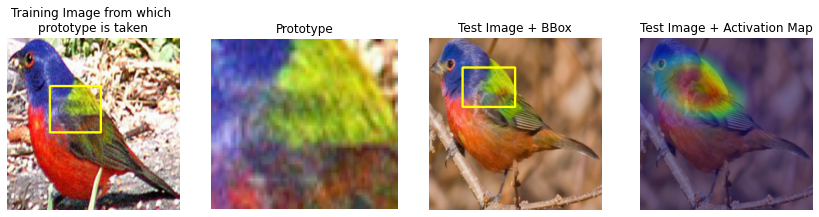

--------------------------------------------------------------
top 2 activated prototype for this image:
prototype index: 152
prototype class identity: 15
activation value (similarity score): 4.846137523651123
last layer connection with predicted class: 1.1776697635650635


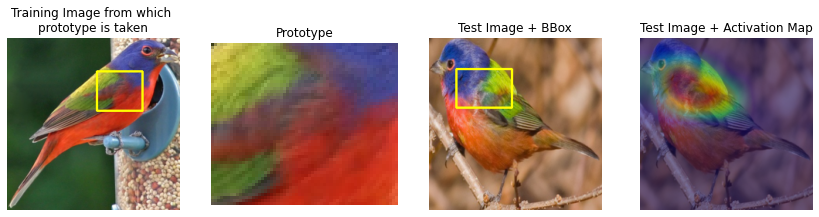

--------------------------------------------------------------
top 3 activated prototype for this image:
prototype index: 154
prototype class identity: 15
activation value (similarity score): 4.095553874969482
last layer connection with predicted class: 1.1301459074020386


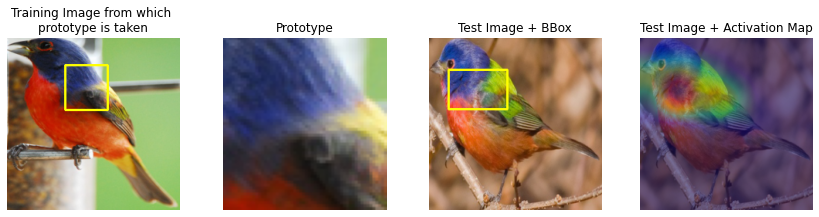

--------------------------------------------------------------
top 4 activated prototype for this image:
prototype index: 151
prototype class identity: 15
activation value (similarity score): 3.922361135482788
last layer connection with predicted class: 1.1861398220062256


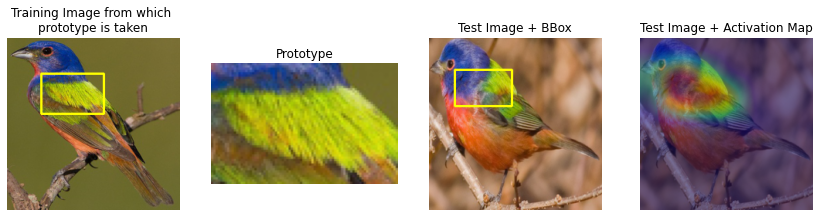

--------------------------------------------------------------
top 5 activated prototype for this image:
prototype index: 155
prototype class identity: 15
activation value (similarity score): 3.7111527919769287
last layer connection with predicted class: 1.1558709144592285


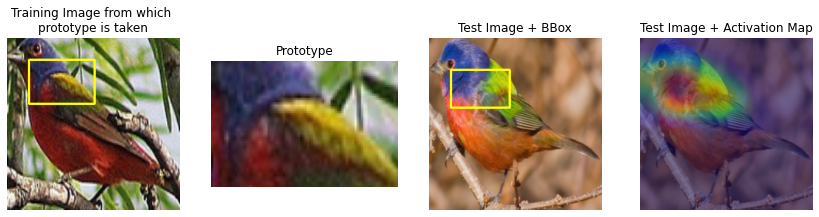

--------------------------------------------------------------
top 6 activated prototype for this image:
prototype index: 153
prototype class identity: 15
activation value (similarity score): 3.5473344326019287
last layer connection with predicted class: 1.1723190546035767


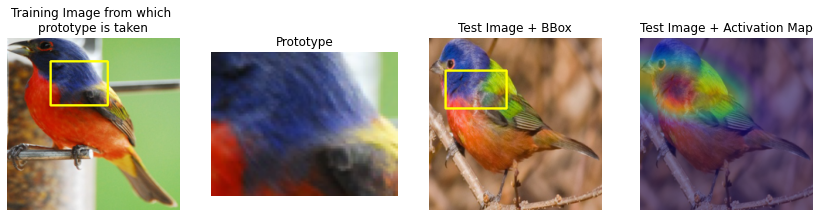

--------------------------------------------------------------
top 7 activated prototype for this image:
prototype index: 156
prototype class identity: 15
activation value (similarity score): 2.4026451110839844
last layer connection with predicted class: 1.0252270698547363


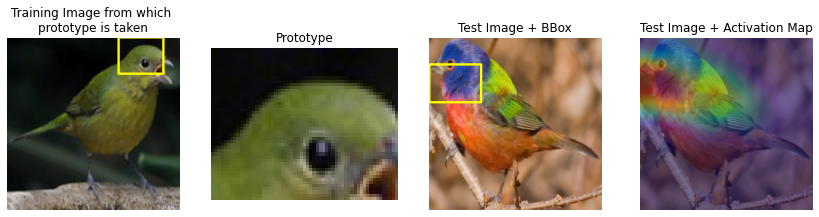

--------------------------------------------------------------
top 8 activated prototype for this image:
prototype index: 157
prototype class identity: 15
activation value (similarity score): 2.2761926651000977
last layer connection with predicted class: 1.117905855178833


--------------------------------------------------------------
top 9 activated prototype for this image:
prototype index: 1796
prototype class identity: 179
activation value (similarity score): 2.099757671356201
last layer connection with predicted class: -2.0552241039695218e-05


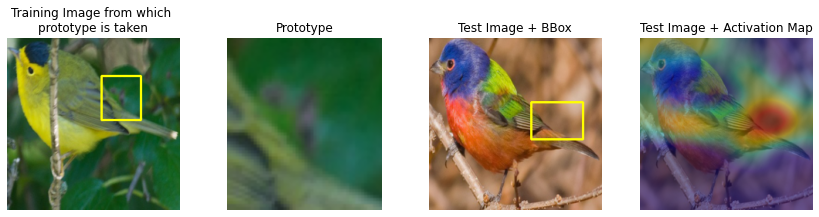

--------------------------------------------------------------
top 10 activated prototype for this image:
prototype index: 1087
prototype class identity: 108
activation value (similarity score): 1.8936526775360107
last layer connection with predicted class: -1.4274161912908312e-05


--------------------------------------------------------------


In [9]:
_, _ = local_analysis(img_variable, show_images=True)

### Attack: Reduce Simlarity with a Prototype

In [10]:
def attack2(img_variable, i=1, idx=0):
    '''
    Perform attack 2 (e.g. make head disappear).
    Arguments:
        img_variable (torch.Tensor): imput image to attack.
        i (int): rank of prototype to attack (in decreasing order of similarity e.g. most similar = 1).
        idx (int): image id in the batch (default: 0)
    '''
    i = i # rank of prototype to attack (in decreasing order of similarity e.g. most similar = 1)
    idx = idx # image index

    images_test = img_variable.cuda()
    labels_test = torch.tensor([test_image_label])
    
    original_img = save_preprocessed_img(os.path.join(save_analysis_path, 'original_img.png'), 
                                         images_test, idx)

    logits, min_distances = ppnet_multi(images_test)
    conv_output, distances = ppnet.push_forward(images_test)
    prototype_activations = ppnet.distance_2_similarity(min_distances)
    prototype_activation_patterns = ppnet.distance_2_similarity(distances)
    if ppnet.prototype_activation_function == 'linear':
        prototype_activations = prototype_activations + max_dist
        prototype_activation_patterns = prototype_activation_patterns + max_dist

    array_act, sorted_indices_act = torch.sort(prototype_activations[idx])
    pid = sorted_indices_act[-i].item()
    print ('Attacking prototype: {}'.format(pid))
    
    activation_pattern = prototype_activation_patterns[idx][sorted_indices_act[-i].item()].detach().cpu().numpy()
    upsampled_activation_pattern = cv2.resize(activation_pattern, dsize=(img_size, img_size),
                                              interpolation=cv2.INTER_CUBIC)

    # show the most highly activated patch of the image by this prototype
    high_act_patch_indices = find_high_activation_crop(upsampled_activation_pattern)
    high_act_patch = original_img[high_act_patch_indices[0]:high_act_patch_indices[1], high_act_patch_indices[2]:high_act_patch_indices[3], :]

    mask = np.zeros((img_size, img_size, 3))
    mask[high_act_patch_indices[0]:high_act_patch_indices[1], high_act_patch_indices[2]:high_act_patch_indices[3], :] = 1
    mask = np.moveaxis(mask, 2, 0)
    mask = torch.from_numpy(mask)
    mask = (mask > 0).cuda()

    clip_min, clip_max = 0, 1
    toTensor = transforms.ToTensor()
    images_test_unprocessed = undo_preprocess_input_function(img_variable).cuda()

    with ctx_noparamgrad_and_eval(ppnet_multi):
        sim = similarity_score(ppnet_multi, ppnet, normalize, images_test_unprocessed, test_image_label, pid)
        print ('Similarity with prototype {} before attack is {:2f}'.format(pid, sim))
        
        images_perturbed, pert, score = pgd(images_test_unprocessed, mask, pid, ppnet_multi, ppnet, normalize, 
                                            attack_steps=10, attack_lr=2/255, attack_eps=8/255, 
                                            clip_min=clip_min, clip_max=clip_max, minimize=True)

        sim = similarity_score(ppnet_multi, ppnet, normalize, images_perturbed, test_image_label, pid)
        print ('Similarity with prototype {} after attack is {:2f}'.format(pid, sim))
    
    visualize_image_grid(torch2numpy, images=[images_test_unprocessed, images_perturbed, pert*127+0.5], 
                         titles=['Original Image', 'Perturbed Image', 'Perturbation'])
    return images_perturbed, pert

image index 0 in batch
Attacking prototype: 150
Similarity with prototype 150 before attack is 5.094854


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Similarity with prototype 150 after attack is 0.552985


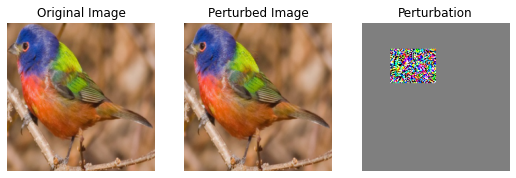

In [11]:
images_perturbed, _ = attack2(img_variable, i=1, idx=0)

### Local Analysis: Attacked Image

Predicted: 135
Actual: 15
Prediction is wrong.
image index 0 in batch
Most activated 10 prototypes of this image:
--------------------------------------------------------------
top 1 activated prototype for this image:
prototype index: 1796
prototype class identity: 179
activation value (similarity score): 2.457120180130005
last layer connection with predicted class: -1.0628916697896784e-06


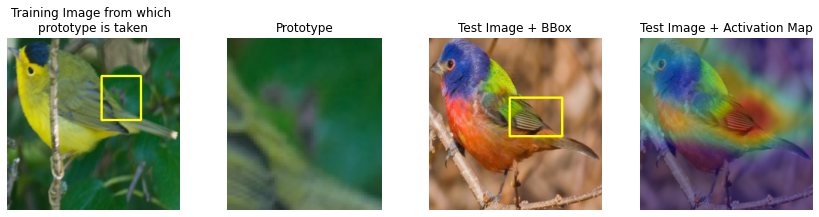

--------------------------------------------------------------
top 2 activated prototype for this image:
prototype index: 1715
prototype class identity: 171
activation value (similarity score): 2.318498134613037
last layer connection with predicted class: -6.290089459071169e-06


--------------------------------------------------------------
top 3 activated prototype for this image:
prototype index: 1087
prototype class identity: 108
activation value (similarity score): 2.0790252685546875
last layer connection with predicted class: 8.654924386064522e-06


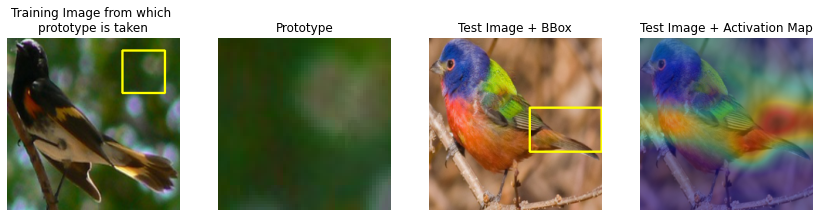

--------------------------------------------------------------
top 4 activated prototype for this image:
prototype index: 744
prototype class identity: 74
activation value (similarity score): 2.0155179500579834
last layer connection with predicted class: 1.4876947716402356e-05


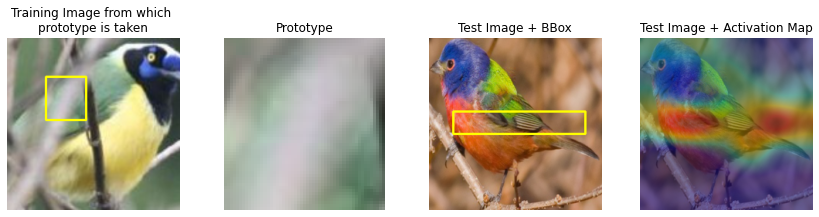

--------------------------------------------------------------
top 5 activated prototype for this image:
prototype index: 1630
prototype class identity: 163
activation value (similarity score): 1.8684818744659424
last layer connection with predicted class: 1.7736063455231488e-05


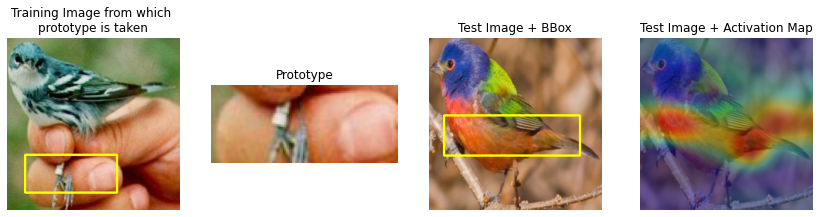

--------------------------------------------------------------
top 6 activated prototype for this image:
prototype index: 1639
prototype class identity: 163
activation value (similarity score): 1.8684818744659424
last layer connection with predicted class: 1.5767518561915495e-05


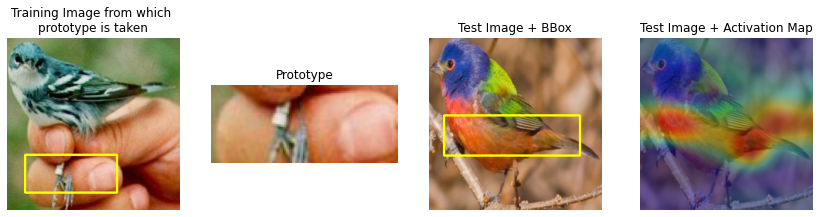

--------------------------------------------------------------
top 7 activated prototype for this image:
prototype index: 1049
prototype class identity: 104
activation value (similarity score): 1.8677752017974854
last layer connection with predicted class: -1.6813417460070923e-05


--------------------------------------------------------------
top 8 activated prototype for this image:
prototype index: 943
prototype class identity: 94
activation value (similarity score): 1.77671217918396
last layer connection with predicted class: 1.4611865481128916e-05


--------------------------------------------------------------
top 9 activated prototype for this image:
prototype index: 1612
prototype class identity: 161
activation value (similarity score): 1.7723366022109985
last layer connection with predicted class: 2.657302320585586e-05


--------------------------------------------------------------
top 10 activated prototype for this image:
prototype index: 1617
prototype class identity: 161
activation value (similarity score): 1.7076785564422607
last layer connection with predicted class: -2.0998550098738633e-05


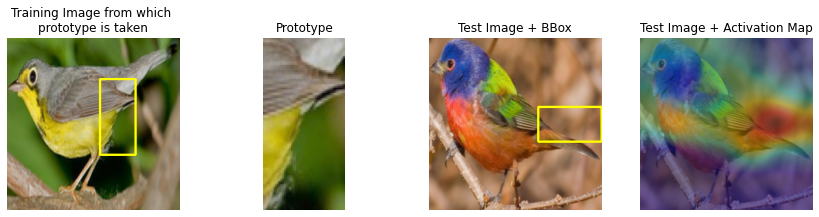

--------------------------------------------------------------


In [12]:
_, _ = local_analysis(normalize(images_perturbed.squeeze(0)).unsqueeze(0), show_images=True)